In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])
        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)            #
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

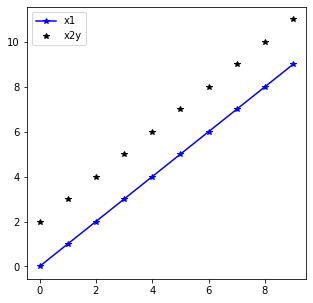

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

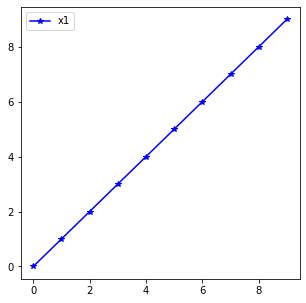

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [153]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self.data.item())}")
        return ax

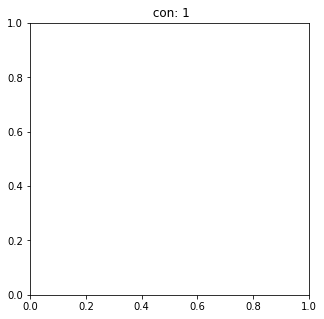

In [13]:
TensorCon(1).show()

## Utils

In [14]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [15]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [16]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [17]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [111]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name, horizon, lookback=72, step=1, min_seq_len=None, max_std= 2, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []
        self.ms = {}        

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, horizon=self.horizon, lookback=self.lookback, step=self.step , **kwargs)
        res.make_ids()
        return res

    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        cat, con = row[self.cat_names].to_numpy().astype(int), row[self.con_names].to_numpy().astype(float)
        return x, tsx, cat, con, y

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        x, tsx, cat, con, y  = self.get_id(idx)
        if (y/(x.std()+1e-7)).std() > self.max_std:
            if idx not in self.skipped:
#                 print(f"idx: {idx};y.std to high: {(y/x.std()).std()} > {self.max_std}")
                self.skipped.append(idx)
            raise SkipItemException()
        
#         print({k:(o,o.dtype,o.shape) for k,o in zip(['x','tsx','cat','con','y'],[x,tsx,cat,con,y])})        
        return (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )

    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [112]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -0.047360 1 2.432810 2 1.853505 3 4.041274 4 4.546992 5 7.184111 6 8.470761 7 8.079718 8 9.194248 9 9.550473 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.349989 1 3.404112 2 3.454652 3 2.733100 4 5.572483 5 6.424255 6 6.766699 7 7.691938 8 8.562481 9 8.869173 10 10.953326 11 13.768112 dtype: float64,1.0,1


In [113]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [114]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 2, 11]), 'cat': torch.Size([3, 1]), 'con': torch.Size([3, 1]), 'y': torch.Size([3, 1, 11])}


(#2) ['ts_0','ts_1']

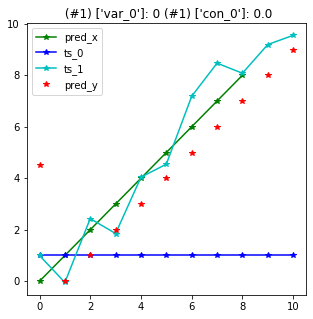

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff762d6bef0>
Traceback (most recent call last):
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/tako/dev/env37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/local/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/local/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


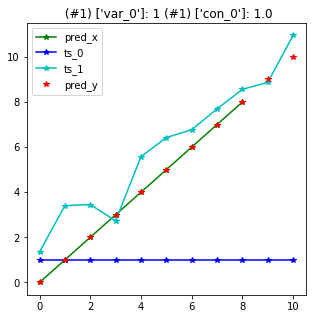

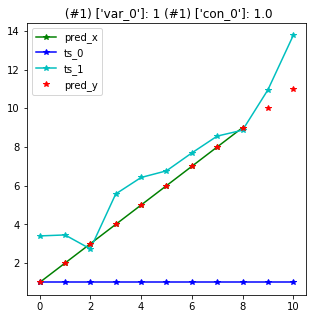

In [115]:
dl.show_batch(max_n=3)

# Intergration Example

In [116]:
from fastseq.data.external import *

In [145]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[-1.575219656459134, -1.5103990108101646, -1.2460380531512467, -1.0865797902316918, -0.5457532451292991, -0.25967703161257094, 0.13267675667855972, 0.772689997310408, 1.2925678505801288, 1.7263461580246775, 1.6089514470275004, 1.497467027040739, 1.247495931741949, 0.41176172776227743, 0.5339717581734547, -0.16119570941999892, -0.7644889578369084, -1.211234269997831, -1.5517555804029914, -1.1436601922607368, -1.2007158679619931, -1.1401993155309416, -0.5151847052705447, -0.17785591649991644, 0.2585478058864358, 0.4714809936368415, 0.6322405490548414, 0.7264503607764277, 0.8534979963994288,...","[[4.448590316612798, 4.262652410102156, 3.7522115166768657, 3.0770620145936975, 2.443690600975246, 2.037381419514389, 1.9629309085108078, 2.214068154834008, 2.681410241611885, 3.1951757319725322, 3.586776928557424, 3.7470933889865146, 3.6608874148256767, 3.405786486614274, 3.117247700369831, 2.9332318496095104, 2.939517025123367, 3.1361032269113913, 3.437212364183514, 3.704883643422659, 3.8036599686112114, 3.6559138592098384, 3.276883013652638, 2.7756878743196833, 2.320916138569559, 2.0823492432740682, 2.169370105305328, 2.58824963779391, 3.234191402440096, 3.9219112555508993, 4.4449225000...",0,0.013956
1,"[[-0.6501089886180599, -0.7789288361381788, -0.9328455673229038, -1.2307575252486413, -1.6001997978939493, -1.259261182181954, -0.7929186407295137, -0.089390692187658, 0.11498981440461772, 0.8584050212617325, 0.7982102255544556, 0.5013612814635569, -0.11214047425346209, -0.7522803393099489, -0.848579758594717, -1.1099862286660274, -0.6006122062156254, -0.6565413161295035, 0.05342980173425955, 0.5636634864649841, 0.7666983863439679, 0.48997374528027166, 0.4111481878506134, -0.41878044644443785, -0.622363146343603, -0.35991230214189074, -0.34187186071382525, 0.6508137424875908, 1.58546712124...","[[7.092031510117114, 6.697149090507281, 6.433076664296221, 6.439736339186216, 6.745195078915727, 7.258103180124517, 7.804035235423877, 8.191881924869085, 8.285671463595772, 8.055397184895645, 7.588213062662962, 7.0558965948001156, 6.650500842168427, 6.511822336249045, 6.67345169646696, 7.047587669916418, 7.454829583910004, 7.688833860460917, 7.592912985637824, 7.1210105758658155, 6.360727639347262, 5.5093823755835905, 4.810737428987904, 4.474086480923903, 4.603825501441349, 5.164120974481046, 5.991049861566832, 6.847957646402502, 7.504661947273114, 7.812881642951358, 7.751805529150673, 7.4...",0,-0.537845
2,"[[0.9580197439614875, 0.26112223634171766, 0.9954489935199211, 0.14014937871114294, -0.15082179504506008, -0.6645366240166946, -1.1573071647555488, -1.1779943735571758, -1.6862618070268736, -1.2281619596318505, -0.8861007033170979, -0.29840539987713044, 0.3236190311141602, 0.695045467225018, 1.1493778298413482, 1.3081748333024112, 1.2230048933024058, 1.2140237811834316, 1.0543040402338564, 0.11366907063432195, -0.04828175689155736, -0.9827378709816442, -1.195895052103562, -1.7082062892521004, -1.2694067406093412, -0.938107329538784, -0.45678547636255984, -0.26283667396114263, 0.77992099056...","[[5.859750155674326, 5.77598780198016, 5.6500187360470395, 5.492406184278229, 5.31884228775722, 5.147604651340082, 4.996593829463796, 4.880431925936656, 4.808092579355595, 4.78144647648692, 4.794958143167708, 4.836583158185542, 4.889720365784178, 4.935902663647788, 4.95779023167035, 4.941981045890675, 4.8811831371934655, 4.775396505578727, 4.631913120161751, 4.464135004903715, 4.289401979910661, 4.126181147498412, 3.991073663423204, 3.896123948897463, 3.846867478084107, 3.841433564216824, 3.8708485686986864, 3.920490387721419, 3.972458466848014, 4.008475201222391, 4.012848449761103, 3.9750...",0,-0.067138
3,"[[2.087067670655819, 1.7676328164909243, 1.395439090713326, 1.3053277245975559, 1.1314999816431703, 1.1503775375918048, 1.354417963248296, 1.4255754981171636, 1.0626868223753143, 0.9176548080514089, 0.43829627090607076, 0.13333752191707848, -0.15293227723955619, -0.5341726752629917, -0.6989507703226152, -0.767261791392032

In [146]:
pd.Series(np.ones(10)).dtype

dtype('float64')

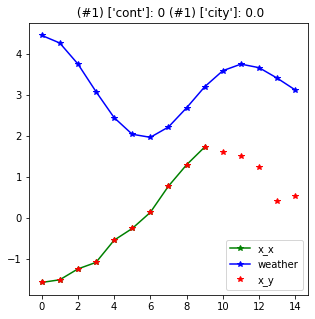

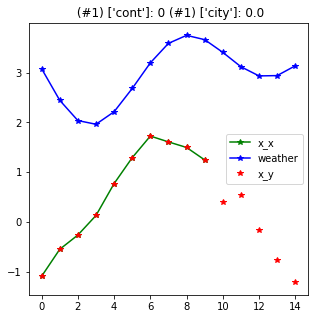

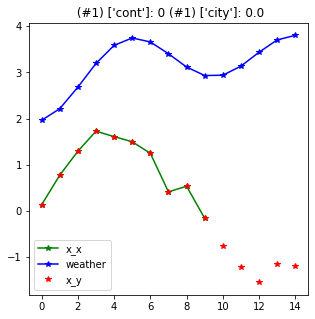

In [149]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3)
dl.show_batch(max_n=3)

In [154]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
